![](https://raw.githubusercontent.com/SunnySuite/Sunny.jl/main/assets/sunny_logo.jpg)

_This is a tutorial for the [Sunny](https://github.com/SunnySuite/Sunny.jl/) package, which enables dynamical simulations of ordered and thermally disordered spins with dipole and higher order moments._




# **Spin Dynamics of the cubic Heisenberg antiferromagnet RbMnF3**
#### Author: Martin Mourigal (mourigal@gatech.edu)
#### Date: September 7, 2022
#### Version: Julia 1.8,  Sunny 0.4

In this tutorial, we will walk through a second example in Su(n)ny and calculate the thermomagnetic and magnetic order properties of RbMnFe<sub>3</sub>. This material is considered the closest realization of an cubic, spin-isotropic Heisenberg antiferromagnet and was studied in detail by many neutron scattering and magnetism experts, in particular for its critical properties in vicinity to T<sub>N</sub> = 83 K.


[1] C G Windsor and R W H Stevenson 1966 Proc. Phys. Soc. 87 501 (https://doi.org/10.1088/0370-1328/87/2/319)   
[2] D A Tennant et al 1994 J. Phys.: Condens. Matter 6 10341 (https://doi.org/10.1088/0953-8984/6/47/017)   
[3] J. C. López Ortiz et al. 2004 Phys. Rev. B 90, 054402 (https://journals.aps.org/prb/abstract/10.1103/PhysRevB.90.054402)

## **Setting up Julia with the necessary packages**

#### A video about how to Install Sunny:
https://mourigal.gatech.edu/public/Sunny-Install-Video-Mourigal.mp4

####  General Information about the Package:
https://github.com/SunnySuite/Sunny.jl

#### Getting Started with Sunny:
https://github.com/SunnySuite/Sunny.jl/blob/main/GettingStarted.md

#### Repository of Tutorials:
https://github.com/SunnySuite/SunnyTutorials

#### Join the Slack workspace of the workshop to ask question:
https://join.slack.com/t/sunny-workshop-2022/shared_invite/zt-1f7urbk1t-A_pvDy6E7s_BGAnTAQMesw

In [1]:
## === Packages ===
using Sunny
using Plots, ProgressMeter, Statistics, Formatting, StaticArrays, LinearAlgebra, DelimitedFiles, OffsetArrays
using GLMakie
Sunny.offline_viewers(); 

## **Setting up the Crystal Structure**

### **Method 1: Specify the entire chemical unit-cell by hand**

Because Su(n)ny properly performs symmetry analysis for bilinear exchange interactions, it is important to provide all atoms in the unit-cell, this can be accomplish directly, or by using a .cif file. Given the picture here:
![RbMnF3_Structure](images/RbMnF3_Structure.png)


In [2]:
## === Define the crystal structure of RbMnF3 by looking at the above figure ===
lat_vecs = lattice_vectors(4.218, 4.218, 4.218, 90.0, 90.0, 90.0);  
bas_vecs = [[0.0000000, 0.000000, 0.0000000],
            [0.5000000, 0.500000, 0.5000000],
            [0.5000000, 0.000000, 0.0000000],
            [0.0000000, 0.500000, 0.0000000],
            [0.0000000, 0.000000, 0.5000000]]; 
bas_typs = ["Mn","Rb","F","F","F"]; 
xtal_rbmnf3_full = Crystal(lat_vecs, bas_vecs; types=bas_typs);

### **Method 2: Use of .cif file**

Obtain a .cif file, for instance from: https://icsd.fiz-karlsruhe.de. In some instances, it is necessary to specify the parameter `symprec` depending on the number of significant digitis in the atoms coordinate in the .cif file. Note that the .cif used from ICSD has made a different choice of the origin of the unti-cell. We will keep the two crystals to show they yield equivalent results.

In [3]:
## === Define the crystal structure of RbMnF3 by importing a .cif file ===
xtal_rbmnf3_full_2 = Crystal("RbMnF3_ICSD#43722.cif",symprec=0.001);
display(xtal_rbmnf3_full_2); # This gives exactly the same result as above with Mn in 1b position

Crystal
HM symbol 'P m -3 m' (221)
Lattice params a=4.25, b=4.25, c=4.25, α=90°, β=90°, γ=90°
Cell volume 76.77
Type 'Rb1', Wyckoff 1a (point group 'm-3m'):
   1. [0, 0, 0]
Type 'Mn1', Wyckoff 1b (point group 'm-3m'):
   2. [0.5, 0.5, 0.5]
Type 'F1', Wyckoff 3c (point group '4/mm.m'):
   3. [0.5, 0.5, 0]
   4. [0.5, 0, 0.5]
   5. [0, 0.5, 0.5]


### **Setting up sub-crystals**

For methods 2a and 2b, the Rb and F atoms in the structure are non-magnetic and we need to hide them before decorating the structure with exchange interactions. This is achieved with the `subcrystal` function.

In [4]:
## === Defining Subcrystals for the Crystals defined in Method 2a and 2b ==
# Note that we have defined the two crystals in slightly different ways
xtal_rbmnf3 = subcrystal(xtal_rbmnf3_full,"Mn");
display(xtal_rbmnf3);

Crystal
HM symbol 'P m -3 m' (221)
Lattice params a=4.218, b=4.218, c=4.218, α=90°, β=90°, γ=90°
Cell volume 75.04
Type 'Mn', Wyckoff 1a (point group 'm-3m'):
   1. [0, 0, 0]


## **Setting up the Exchange Interactions and Local Hilbert Space**

### **Setting up the Spin System**
We will now create a `SpinSystem` associated with this `Crystal`. To do so, we need to look at possible equivalent exchange interactions. 

In [6]:
## === Explore Single-Ion and Exchange Anisotropies Allowed by Symmetry ===
print_symmetry_table(xtal_rbmnf3, 6.0);
#view_crystal(xtal_rbmnf3, 4.0)

Site 1
Type 'Mn', position [0, 0, 0], multiplicity 1
Allowed g-tensor: | A  0  0 |
                  | 0  A  0 |
                  | 0  0  A |
Allowed anisotropy in Stevens operators 𝒪[k,q]:
    c₁*(𝒪[4,0]+5𝒪[4,4]) +
    c₂*(𝒪[6,0]-21𝒪[6,4])

Bond(1, 1, [1, 0, 0])
Distance 4.218, coordination 6
Connects 'Mn' at [0, 0, 0] to 'Mn' at [1, 0, 0]
Allowed exchange matrix: | A  0  0 |
                         | 0  B  0 |
                         | 0  0  B |

Bond(1, 1, [1, 1, 0])
Distance 5.9652, coordination 12
Connects 'Mn' at [0, 0, 0] to 'Mn' at [1, 1, 0]
Allowed exchange matrix: | A  C  0 |
                         | C  A  0 |
                         | 0  0  B |



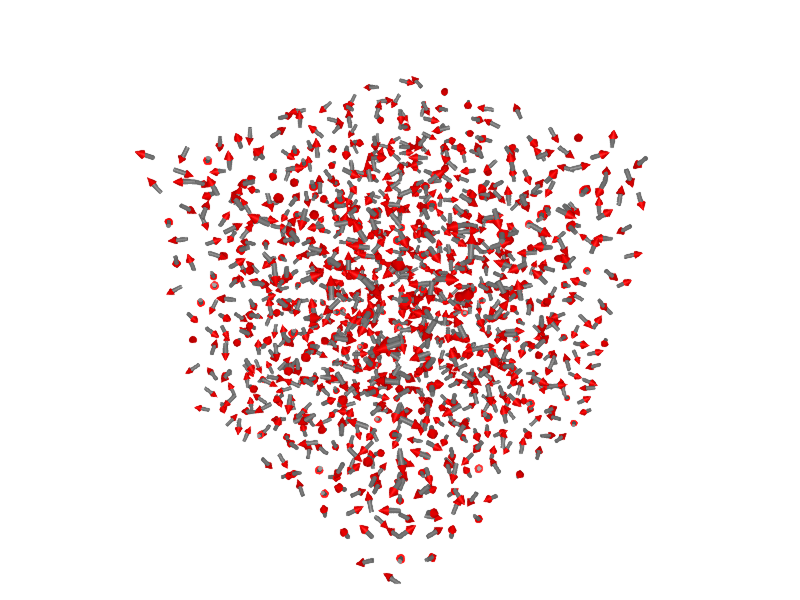

In [13]:
## === Define the Local Hilbert Space ===
val_g =  2.000; # g-factor 
val_K = +0.005; # Quartic K-anisotropy  Kxxxx(S^x)^4 + Kyyyy(S^y)^4 + Kzzzz(S^z)^4
val_A = +0.001; # Quadratric K-anisotropy Axx(S^x)^2 + Ayy(S^y)^2 + Azz(S^z)^2
g    = val_g*diagm(0 => [1, 1, 1]);
N    = 0;
S    = 5/2;
lhs  = SiteInfo(1; N=N, g=g, spin_rescaling=S);  # Local Hilbert Space
sia = anisotropy(val_A*(𝒮[1]^2 + 𝒮[2]^2 + 𝒮[3]^2) + val_K*(𝒮[1]^4 + 𝒮[2]^4 + 𝒮[3]^4), 1, "Quartic Single Ion");


## === Exchange Interactions ===
val_J1 = 0.580;
val_d1 = 1.000;
val_J2 = 0*0.040;
val_d2 = 1.000;
val_a2 = 0*0.000;
J1    = exchange(val_J1*[1 0 0; 0 val_d1 0; 0 0 val_d1], Bond(1, 1, [1, 0, 0]) );
J2    = exchange(val_J2*[val_d2 val_a2 0; val_a2 val_d2 0; 0 0 1], Bond(1, 1, [1, 1, 0]) );

## === Super Cell ===
scd  = (10,10,10); #Super Cell Dimension?

## === Construct Spin System ===
sys_rbmnf3 = SpinSystem(xtal_rbmnf3, [J1,J2,sia], scd, [lhs]);
rand!(sys_rbmnf3);
plot_spins(sys_rbmnf3,arrowlength=0.5, linewidth=0.5, arrowsize=1.0)


## **Thermalizing the system and calculating its structure factor**

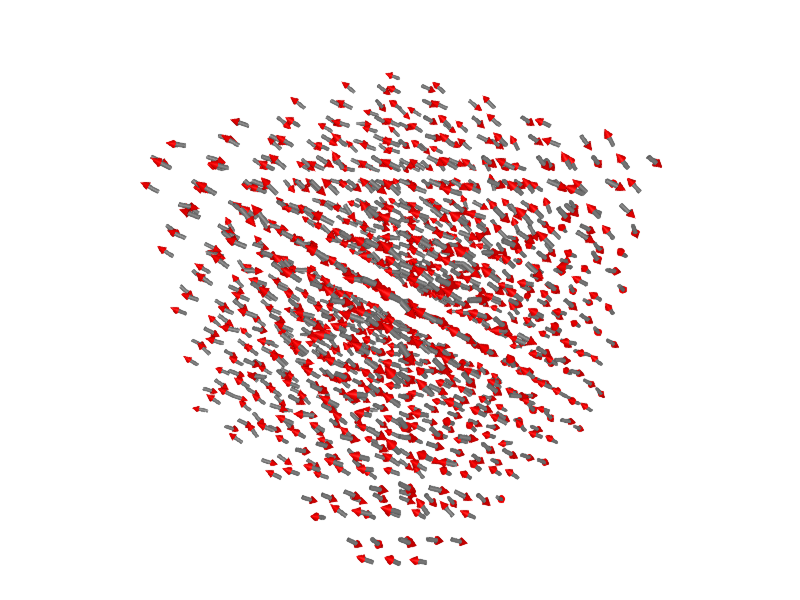

In [14]:
## === Construct Langevin Sampler ===
nLA = 50;   # Number of Langevin time steps performed each time the sampler is invoked
α   = 0.1;  # Langevin damping, usually 0.05-0.2 is good.
dt  = 0.01; # Time steps during Langevin evolution
kT  = 20*val_J1; # Initializing spin system at some finite temperature corresponding to 20 times J1 (to be well paramagnetic)
sam_LA_rbmnf3  = LangevinSampler(sys_rbmnf3, kT, α, dt, nLA);

## === Thermalize system to the temperature said below using Langevin===
kT     = 1.1*val_J1; # Target temperature in meV
nTherm = 100; # Number of times the sampler is invoked to thermalize
set_temp!(sam_LA_rbmnf3,kT); 
thermalize!(sam_LA_rbmnf3,nTherm);
plot_spins(sys_rbmnf3,arrowlength=0.5, linewidth=0.5, arrowsize=1.0)

In [15]:
## === Do Simulations at a Given Temperature===
kT  = 1.0; # Target temperature in meV
set_temp!(sam_LA_rbmnf3,kT); 

##  === Calculate SQ ===
nsam        = 10; # Number of samples that are averaged over (usually 10 is good)
nTherm      = 10;
bz_size     = (4,4,4); # Size of the resulting extended Brillouin zone after FFT
@time begin
sq_rbmnf3 = static_structure_factor(sys_rbmnf3, sam_LA_rbmnf3;
             nsamples=nsam, bz_size=bz_size, thermalize=nTherm, verbose=false, reduce_basis=true, dipole_factor=true)
end

  7.560899 seconds (41.06 M allocations: 2.413 GiB, 7.54% gc time, 80.27% compilation time)


40x40x40x1 StructureFactor

## **Plotting the structure factor**

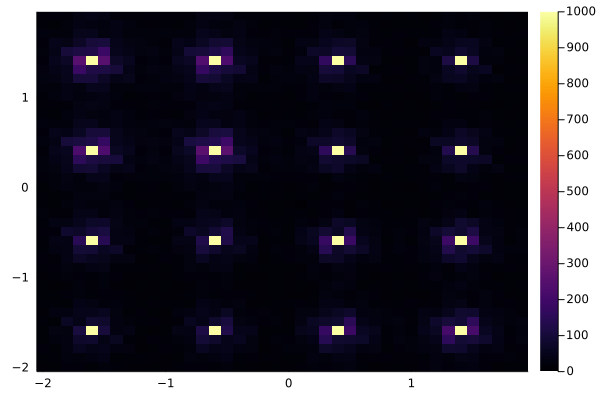

In [16]:
#  === Create a function to plot S(Q) ===
function PlotSQ(input_sq, input_sys; Slice, Imax)
    Q1   = range(input_sq.sfactor.offsets[1],length=size(input_sq.sfactor)[1])/size(input_sys.lattice)[1];
    Q2   = range(input_sq.sfactor.offsets[2],length=size(input_sq.sfactor)[2])/size(input_sys.lattice)[2];
    Q3   = range(input_sq.sfactor.offsets[3],length=size(input_sq.sfactor)[3])/size(input_sys.lattice)[3];
    midQ = Int64(size(Q1)[1]/2);
    Int = input_sq.sfactor[:,:,Slice,0]/prod(size(input_sys.lattice));
    return display(Plots.heatmap(Q1,Q2,Int,clim=(0,Imax),fmt = :png));   
end

#  === Plot a give slice in the system ===
PlotSQ(sq_rbmnf3, sys_rbmnf3; Slice=5, Imax=1000)


## **Calculating the energy and specific heat versus temperature**

In [17]:
#  === Parameters of Cool-Down
nTherm  = 10;
nsamp   = 100;
kTSchedule = range(10.0,0.1,step=-0.1)
prog  = Progress(length(kTSchedule); dt=1.0, desc="Super Cool Down: ", color=:red); # Verbose
en_avg  = Float64[];
en_var = Float64[];
for i in 1:length(kTSchedule)
    # Thermalize the system
    set_temp!(sam_LA_rbmnf3,kTSchedule[i]);
    thermalize!(sam_LA_rbmnf3,nTherm);
    # Sample the system
    en_dummy = Float64[];
    for j in 1:nsamp
        sample!(sam_LA_rbmnf3)    
        push!(en_dummy,energy(sys_rbmnf3))
    end
    push!(en_avg,mean(en_dummy));
    push!(en_var,Statistics.var(en_dummy));
    next!(prog);        
end

Super Cool Down: 100%|██████████████████████████████████| Time: 0:02:35


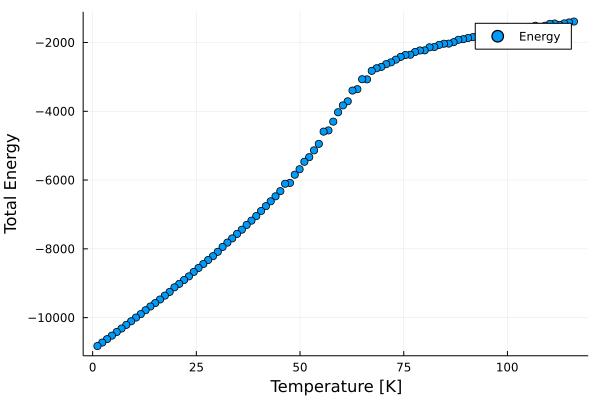

In [18]:
#  === Plotting the Energy versus Temperature
p1=Plots.plot(kTSchedule*11.602,en_avg,    
seriestype = :scatter,
label = "Energy",
xlabel = "Temperature [K]",
ylabel = "Total Energy",
fmt = :png)

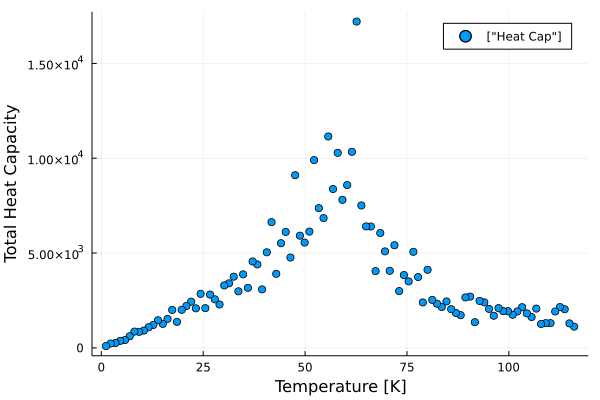

In [19]:
#  === Plotting the Specific Heat versus Temperature
p2=Plots.plot(kTSchedule*11.602,en_var./kTSchedule,    
seriestype = :scatter,
label = ["Heat Cap"],
xlabel = "Temperature [K]",
ylabel = "Total Heat Capacity",
fmt = :png)
